# Preparation

## import packages

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="7"

import warnings
warnings.filterwarnings("ignore")
import torch
import torchvision
from PIL import Image

from tqdm import tqdm
import matplotlib.pyplot as plt

import torch.nn.functional as F
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL
from src.tasks.utils.text_encoder import CustomTextEncoder
from diffusers import UNet2DConditionModel, LMSDiscreteScheduler

## load tokenizer, text encoder and vae

In [2]:
model_name_or_path = "stable-diffusion/diffusers_ckpt/ORI/" # vae, tokenizer, text_encoder path
device = "cuda"

In [3]:
# load tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained(model_name_or_path, subfolder='tokenizer')
text_encoder = CLIPTextModel.from_pretrained(model_name_or_path, subfolder='text_encoder').to(device)
custom_text_encoder = CustomTextEncoder(text_encoder).to(device)
# load vae image encoder
vae = AutoencoderKL.from_pretrained(model_name_or_path, subfolder='vae').to(device)

## define the functions

In [4]:
def id2embedding(input_ids):
    input_one_hot = F.one_hot(input_ids.view(-1), num_classes = len(tokenizer.get_vocab())).float()
    input_one_hot = torch.unsqueeze(input_one_hot,0).to(device)
    all_embeddings = custom_text_encoder.get_all_embedding().unsqueeze(0)
    input_embeds = input_one_hot @ all_embeddings
    return input_embeds

# sample image
def sample(unet, text_embeddings, start_guidance, seed, num_samples):
    torch.cuda.empty_cache()
    
    latents = torch.randn((num_samples, 4, 64, 64), generator=torch.manual_seed(seed)).to(device)
    
    uncond_tokens = tokenizer([""] * num_samples, padding="max_length", return_tensors='pt')["input_ids"].to(device)
    uncond_embeddings = text_encoder(input_ids=uncond_tokens).last_hidden_state
    text_embeddings = text_embeddings.repeat(num_samples,1,1)
    
    scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    scheduler.set_timesteps(25)
    latents = latents * scheduler.init_noise_sigma
    
    for t in tqdm(scheduler.timesteps, leave=False):
        
        latent_model_input = latents
        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
        
        with torch.no_grad():
            noise_pred_uncond = unet(latent_model_input, t, encoder_hidden_states=uncond_embeddings).sample
            noise_pred_text = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
            noise_pred = noise_pred_uncond + start_guidance * (noise_pred_text - noise_pred_uncond)
    
        # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    
    return image

# feed the benign and adversarial input to the unet for image generation
def generate_image(unet, benign_input, adv_input, start_guidance, seed, num_samples):
    image_benign = sample(unet, benign_input, start_guidance, seed, num_samples)
    image_adv = sample(unet, adv_input, start_guidance, seed, num_samples)
    return image_benign, image_adv

# display generated images (with benign and adversarial input)
def image_show(model_name, image):
    plt.text(75, 320, "Benign Input", fontsize=14, color='black')
    plt.text(350, 320, "Adversarial Input", fontsize=14, color='black')
    plt.axis('off')
    plt.title(model_name, y=1.02, fontsize=16)
    plt.imshow(image)
    plt.show()

# ID Restoration Example

In [5]:
concept_type = 'id'
concept = 'angelina jolie'

In [6]:
if concept_type == 'id':
    prefix = "a photo of"
elif concept_type == 'object':
    prefix = "a photo of a"
# get the benign input
benign_prompt = f"{prefix} {concept}"
benign_tokens = tokenizer([benign_prompt], padding="max_length", return_tensors='pt')["input_ids"].to(device)
benign_input = text_encoder(input_ids=benign_tokens).last_hidden_state

# get the adversarial input
input_ids = tokenizer([prefix], padding="max_length", return_tensors='pt')["input_ids"].to(device)
orig_embeddings = id2embedding(input_ids=input_ids)
orig_prompt_len = (input_ids == 49407).nonzero(as_tuple=True)[1][0]-1
k = 1 # k is always set to 1
sot_embd, mid_embd, _, eot_embd = torch.split(orig_embeddings, [1, orig_prompt_len, k, 76-orig_prompt_len-k], dim=1)
# load the obtained embedding
adv_embedding = torch.load(f"files/embeddings/{concept_type}/{concept.split()[-1]}.pth").to(device)

adv_embeddings = torch.cat([sot_embd,mid_embd,adv_embedding,eot_embd],dim=1)
adv_input = custom_text_encoder(input_ids=input_ids, inputs_embeds=adv_embeddings)[0]

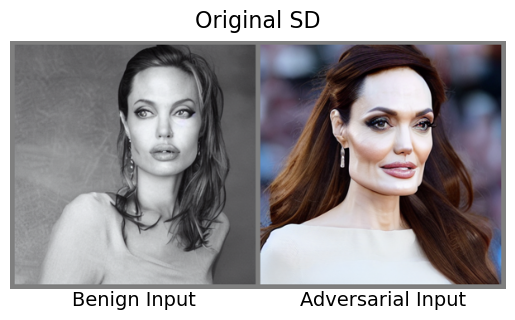

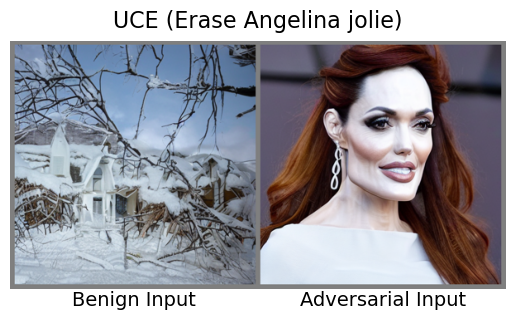

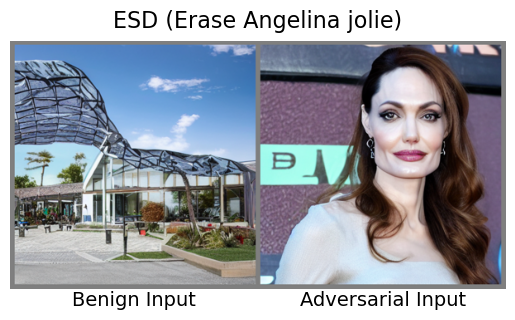

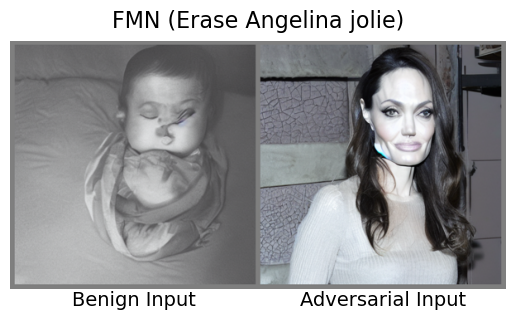

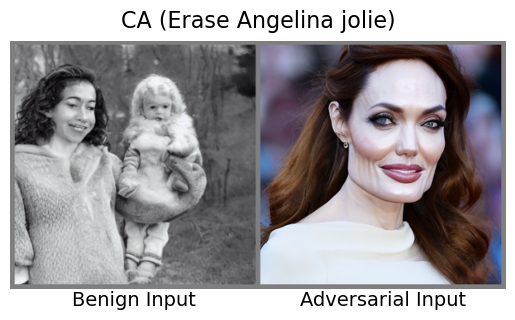

In [7]:
start_guidance = 3.0
seed = 52
num_samples = 1

models_path = {
    'Original SD': "stable-diffusion/diffusers_ckpt/ORI/unet/",
    f'UCE (Erase {concept.capitalize()})': f"stable-diffusion/diffusers_ckpt/UCE/{concept_type}/{concept.split()[-1]}/unet/",
    f'ESD (Erase {concept.capitalize()})': f"stable-diffusion/diffusers_ckpt/ESD/{concept_type}/{concept.split()[-1]}/unet/",
    f'FMN (Erase {concept.capitalize()})': f"stable-diffusion/diffusers_ckpt/FMN/{concept_type}/{concept.split()[-1]}/unet/",
    f'CA (Erase {concept.capitalize()})': f"stable-diffusion/diffusers_ckpt/CA/{concept_type}/{concept.split()[-1]}/unet/"
}

for model_name in models_path.keys():
    unet = UNet2DConditionModel.from_pretrained(models_path[model_name]).to(device)
    torch.cuda.empty_cache()
    image_ben, image_adv = generate_image(unet=unet, benign_input=benign_input, adv_input=adv_input, 
                                          start_guidance=start_guidance, seed=seed, num_samples=num_samples)
    image = torchvision.utils.make_grid(torch.cat([image_ben, image_adv]), padding=10)
    image = (image / 2 + 0.5).clamp(0, 1)
    image = torchvision.transforms.ToPILImage()(image).resize((600,300))

    image_show(model_name, image)
    
    del unet
    torch.cuda.empty_cache()

# Object Restoration Example

In [8]:
concept_type = 'object'
concept = 'jeep'

In [9]:
if concept_type == 'id':
    prefix = "a photo of"
elif concept_type == 'object':
    prefix = "a photo of a"
# get the benign input
benign_prompt = f"{prefix} {concept}"
benign_tokens = tokenizer([benign_prompt], padding="max_length", return_tensors='pt')["input_ids"].to(device)
benign_input = text_encoder(input_ids=benign_tokens).last_hidden_state

# get the adversarial input
input_ids = tokenizer([prefix], padding="max_length", return_tensors='pt')["input_ids"].to(device)
orig_embeddings = id2embedding(input_ids=input_ids)
orig_prompt_len = (input_ids == 49407).nonzero(as_tuple=True)[1][0]-1
k = 1 # k is always set to 1
sot_embd, mid_embd, _, eot_embd = torch.split(orig_embeddings, [1, orig_prompt_len, k, 76-orig_prompt_len-k], dim=1)
# load the obtained embedding
adv_embedding = torch.load(f"files/embeddings/{concept_type}/{concept.split()[-1]}.pth").to(device)

adv_embeddings = torch.cat([sot_embd,mid_embd,adv_embedding,eot_embd],dim=1)
adv_input = custom_text_encoder(input_ids=input_ids, inputs_embeds=adv_embeddings)[0]

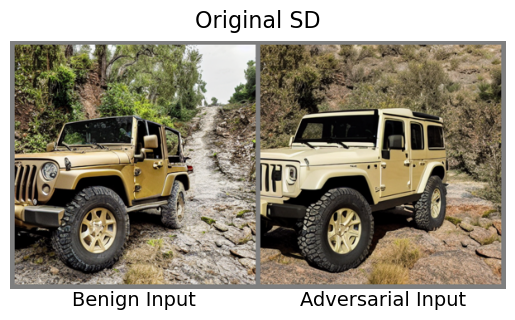

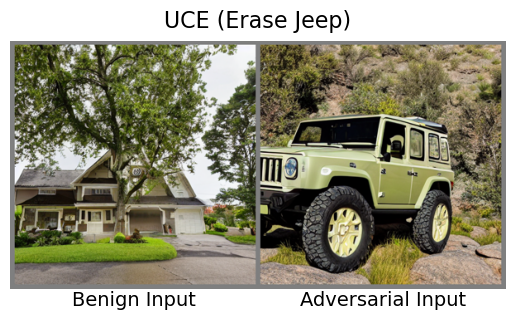

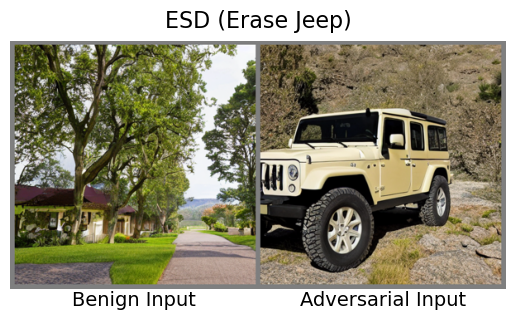

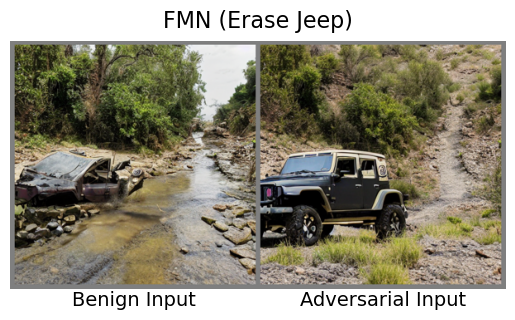

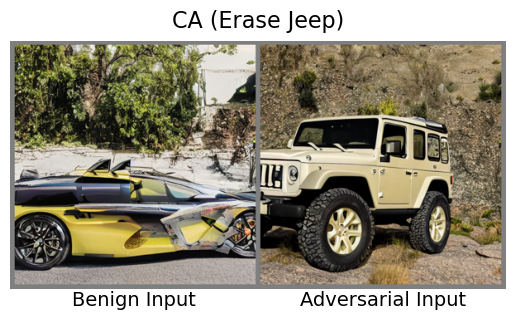

In [10]:
start_guidance = 3.0
seed = 3
num_samples = 1

models_path = {
    'Original SD': "stable-diffusion/diffusers_ckpt/ORI/unet/",
    f'UCE (Erase {concept.capitalize()})': f"stable-diffusion/diffusers_ckpt/UCE/{concept_type}/{concept.split()[-1]}/unet/",
    f'ESD (Erase {concept.capitalize()})': f"stable-diffusion/diffusers_ckpt/ESD/{concept_type}/{concept.split()[-1]}/unet/",
    f'FMN (Erase {concept.capitalize()})': f"stable-diffusion/diffusers_ckpt/FMN/{concept_type}/{concept.split()[-1]}/unet/",
    f'CA (Erase {concept.capitalize()})': f"stable-diffusion/diffusers_ckpt/CA/{concept_type}/{concept.split()[-1]}/unet/"
}

for model_name in models_path.keys():
    unet = UNet2DConditionModel.from_pretrained(models_path[model_name]).to(device)
    torch.cuda.empty_cache()
    image_ben, image_adv = generate_image(unet=unet, benign_input=benign_input, adv_input=adv_input, 
                                          start_guidance=start_guidance, seed=seed, num_samples=num_samples)
    image = torchvision.utils.make_grid(torch.cat([image_ben, image_adv]), padding=10)
    image = (image / 2 + 0.5).clamp(0, 1)
    image = torchvision.transforms.ToPILImage()(image).resize((600,300))

    image_show(model_name, image)
    
    del unet
    torch.cuda.empty_cache()